## Import CSVs

In [1]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
data=pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')
data.head(5)

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


## Sample the data

In [2]:
landmark_list = [str(x) for x in list(range(1000,3000))]
data_sample = data[data['landmark_id'].isin(landmark_list)]
# data_sample.landmark_id.value_counts()

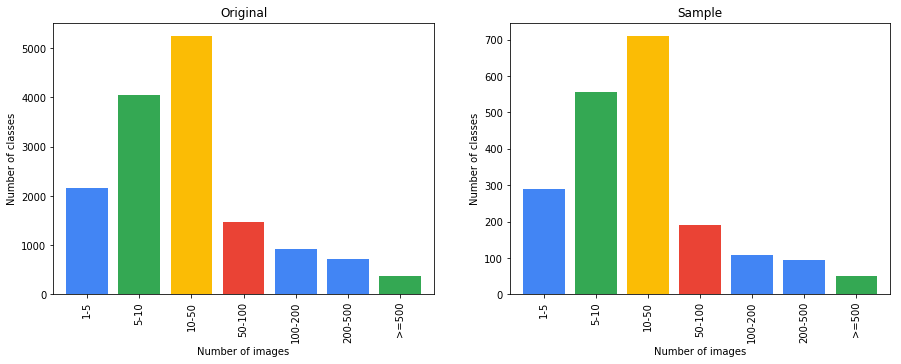

In [22]:
# Check data distribution
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)

## Download Images

In [23]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

'''Split to test and train'''
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.01 #takes 1% from each class as holdout data

import random
random.seed(42)
for landmark_id in set(data_sample_resize['landmark_id']):
    n=1
    t = data_sample_resize[(data_sample_resize.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample_resize[data_sample_resize.id.isin(test)] #holdout dataset
    data_tr = data_sample_resize[data_sample_resize.id.isin(training)] #training dataset
    data_test = data_test.append(data_t)  
    data_training_all = data_training_all.append(data_tr)
    n+=1

print ('2. train and test set created')


'''Split into train and validation set'''
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')

1. URLs overwritten
2. train and test set created
3. train and validation set created


In [19]:
print (len(data_train))
print (len(data_valid))
print (len(data_test))

130551
31651
1183


Create directories 'train_images_model', 'validation_images_model', 'test_images_from_train' inside 'Data' folder before running the code ahead.

In [25]:
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    with open('../Data/' + folder + '/image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
    
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
i=0
for link in data_train['url']:              #looping over links to get images
    if os.path.exists('../Data/train_images_model/'+str(data_train['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'train_images_model')
    os.rename('../Data/train_images_model/image.jpg','../Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine
#         break
print('4. train images fetched')

    
i=0
for link in data_valid['url']:              #looping over links to get images
    if os.path.exists('../Data/validation_images_model/'+str(data_valid['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'validation_images_model')
    os.rename('../Data/validation_images_model/image.jpg','../Data/validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine
#         break
print('5. Validation images fetched')

i=0
for link in data_test['url']:              #looping over links to get images
    if os.path.exists('../Data/test_images_from_train/'+str(data_test['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'test_images_from_train')
    os.rename('../Data/test_images_from_train/image.jpg','../Data/test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine
#         break
print('6. Test images fetched')

4. train images fetched
5. Validation images fetched
6. Test images fetched


## Data Preprocessing
Creating folders for each landmark ID (Class label)

In [26]:
##create folders for landmark IDs in Training folder
import pandas as pd
import os
import shutil
from shutil import copyfile
import urllib

train_data = data_train

temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = '../Data/' + folder + '/'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1
createfolders(temp,'train_images_model')
print ('Train folders created')

rootdirpics = r'../Data/train_images_model/'
rootdirfolders = r'../Data/train_images_model/'

def transformdata(data,path1, path2):

    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >1000)):
#                 print('move')
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 1000)):
                os.remove(inpath)
        n+=1

transformdata(train_data,rootdirpics, rootdirfolders)
print ('Train images moved')

Train folders created
Train images moved


In [27]:
##create folders for landmark IDs in Validation folder

temp = pd.DataFrame(data_valid.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
createfolders(temp,'validation_images_model')
print ('Validation folders created')

#make folders for landmark ID which had no images in validation sets - required for codes running next
available = [int((x[0].split('/'))[-1]) for x in os.walk(r'../Data/validation_images_model/') if len((x[0].split('/'))[-1]) > 0]
new = [str(x) for x in range(1000,2999) if x not in available]
for i in new:
    path = '../Data/validation_images_model/' + i
    if not os.path.exists(path):
        os.makedirs(path)

rootdirpics = r'../Data/validation_images_model/'
rootdirfolders = r'../Data/validation_images_model/'
transformdata(data_valid,rootdirpics, rootdirfolders)
print ('Validation images moved')

Validation folders created
Validation images moved


## Display Images

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

def displayLandmarkImagesLarge(urls, category_name):
    img_style = "width: 200px; height:160px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

category = data['landmark_id'].value_counts().keys()[15]
urls = data[data['landmark_id'] == category]['url']
displayLandmarkImagesLarge(urls, "")

In [3]:
# Visualize 6 images for each of the first 4 landmarks, ordered by the number of occurences.
LANDMARK_NUMBER = 4
IMAGES_NUMBER = 6
landMarkIDs = pd.Series(data['landmark_id'].value_counts().keys())[0:LANDMARK_NUMBER]
for landMarkID in landMarkIDs:
    url = data[data['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url, "")

In [28]:
pd.Series(data['landmark_id'].value_counts().keys())[1:4]

1    6051
2    6599
3    9779
dtype: object

### Predictions using weights from ImageNet

Before proceeding with any model training, VGG16 architecture trained on Imagenet dataset is picked up and is used to predict on the images that we had. Observation: Imagenet weights are successfully able to capture the generic features from landmarks.

In [6]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model =VGG16(weights = 'imagenet', include_top = True)

img_path = r'..\Data\train_images_model\1147\5cefb03a8c8ad42a.jpg'
img = image.load_img(img_path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top = 3)[0])

# 0a0667fc2436a04b = stupa (17%)
# 0b48dd3b81d5b6ba = triumphal_arch(25%)

Predicted: [('n02859443', 'boathouse', 0.19038843), ('n03028079', 'church', 0.13606071), ('n03933933', 'pier', 0.10720713)]


# Model Training - Transfer Learning

In [8]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import csv
import os
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
import math
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import tensorflow as tf
import keras

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data_dir = '../Data/train_images_model'
validation_data_dir = '../Data/validation_images_model'

#counts the number of files in subdirectories of a given directory. 
#outputs the count of images and label of each image in order of reading.

def count(dir):
    i = 1000
    count = []
    while i <= 2999:
        f = str(i)
#         print (f)
        for root, dirs, files in os.walk(dir +'/'+ f):  # loop through startfolders
            for pic in files:
                count.append(f)   
            i += 1
    print (len(count))
    return ([len(count),count])

nb_train_samples = count(train_data_dir)
nb_validation_samples = count(validation_data_dir)

# nb_train/validation_samples is a list of lists of the format [len(count),count]. len(count) is the total number of images in 
# train/validation folder. count is a list of class labels i.e. landmark IDs of the images read.

129690
31680


In the next steps, a batch size will be defined, which needs to be a factor of both the number of train and validation images. I had to remove a certain number of images in the process. Use the code below to move some images out of the train/validation folder in order to get a common factor in the range of 100-1000 (approx.). This common factor will be used as the batch size going forward.
A folder named 'Data/moved_images' has to be created before executing the below. 

In [ ]:
CL = '2061' #class from which to move images
NI = 946 #Number of images to be moved

i = 0
for files in os.listdir(r'../Data/train_images_model/' + CL):    # loop through startfolders
            i+=1
            inpath = r'../Data/train_images_model/' + CL + '/' + files
            outpath = r'../Data/moved_images' 
            shutil.move(inpath, outpath)
            if i == NI:
                break

#### Converting images to vectors using weights from ImageNet on VGG16

In [ ]:
## Had to remove images (1046 - 6c39ce7ee33cea49.jpg)(1310 - f2bf3d0a94733000.jpg) (1834 - 35494ec38ca8b6ff.jpg) 
##(1946 - aa108073efc35e13.jpg) (2729 - 43608f66f2f680e3.jpg) (2975 - bf4b45efc3dfda07.jpg) 
# because were throwing error while running the code.

img_width, img_height = 96, 96 # dimensions of downloaded images.
top_model_weights_path = 'bottleneck_fc_model.h5' # A file with this name would be saved later in the code
epochs = 5
batch_size = 990 #As found in the previous step
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range = 0.5,
                                 brightness_range = [0.5,1.5])

#     build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3))
    print ('start1')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means our generator will only yield batches of data, no labels
        shuffle=False) # our data will be in order
    
#     the predict_generator method returns the output of a model, given a generator that yields batches of numpy data
    print ('start2')
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples[0] // batch_size) 
    print ('bottleneck_features_trained')
    
    
    with open('bottleneck_features_train.npy', 'wb') as features_train_file:
        np.save(features_train_file, bottleneck_features_train)
    print ('Train done')
    

## Had to remove (2061 - a32ee99990779b22.jpg) because was throwing an error
    datagen = ImageDataGenerator(rescale=1. / 255) #No image augmentation in validation dataset
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    print ('validation predict start')
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples[0] // batch_size)
    
    with open('bottleneck_features_validation.npy', 'wb') as features_validation_file:
        np.save(features_validation_file, bottleneck_features_validation)
    print ('validation done')
save_bottleneck_features()

start1
Found 129690 images belonging to 2000 classes.
start2


/home/garganisha20/anaconda3/lib/python2.7/site-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


bottleneck_features_trained
Train done
Found 31680 images belonging to 2000 classes.
validation predict start


#### Initializing the weights on top 3 layers

In [3]:
epochs = 5
batch_size = 990
import numpy as np

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(nb_train_samples[1])
    train_labels = [str(int(train_label) - 1000) for train_label in train_labels] 
    #Had to subtract 1000 because class labels should start from 0. In this case, class labels had a range from 1000 to 2999. 
#     print (train_labels)
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(nb_validation_samples[1])
    validation_labels = [str(int(validation_label) - 1000) for validation_label in validation_labels]
    
#     print (validation_labels)
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    n_class = 2000 #number of classes fed to the model
    model.add(Dense(n_class, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    train_labels = to_categorical(train_labels, n_class)
    validation_labels = to_categorical(validation_labels, n_class)
    
    print ('model fit starting')
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

train_top_model()

model fit starting
Train on 129690 samples, validate on 31680 samples
Epoch 1/5
129690/129690 [==============================] - 17s 128us/step - loss: 5.4021 - acc: 0.1554 - val_loss: 4.6540 - val_acc: 0.2455

#### Compile and train the entire model

In [47]:
img_width, img_height = 96, 96
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '../Data/train_images_model'
validation_data_dir = '../Data/validation_images_model'
batch_size = 240
epochs = 32
def trainCNN():

    # build the VGG16 network

    base_model = applications.VGG16(weights='imagenet',include_top= False,input_shape=(96,96,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dense(256, activation='relu'))
    n_class = 2000
    top_model.add(Dense(n_class, activation='softmax'))
    top_model.load_weights(top_model_weights_path) #Load the weights initialized in previous steps
    

    model = Model(input= base_model.input, output= top_model(base_model.output))
    
    # set the first 16 layers to non-trainable (weights will not be updated) - 1 conv layer and three dense layers will be trained
    for layer in model.layers[:16]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-8, decay=0.0),
                  metrics=['accuracy'])
    print ('Compilation done.')
    
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=90,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range = 0.5)
    
    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    np.save('class_indices.npy', train_generator.class_indices)

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    print ('Model fit begins...')
    model.fit_generator(
        train_generator,
        steps_per_epoch=340,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=150,
        callbacks=[ModelCheckpoint(filepath=top_model_weights_path, save_best_only=True, save_weights_only=True)]
        )
    
    model.save_weights(top_model_weights_path)

trainCNN()

Compilation done.
Model fit begins...
Epoch 1/32 
340/340 [==============================] - 856s 3s/step - loss: 4.1731 - acc: 0.2781 - val_loss: 2.5638 - val_acc: 0.4808 
Epoch 2/32 
340/340 [==============================] - 827s 3s/step - loss: 2.8295 - acc: 0.4361 - val_loss: 2.0123 - val_acc: 0.5773 
Epoch 3/32 
340/340 [==============================] - 833s 3s/step - loss: 2.4125 - acc: 0.4991 - val_loss: 1.7364 - val_acc: 0.6215 
Epoch 4/32 
340/340 [==============================] - 834s 3s/step - loss: 2.1790 - acc: 0.5363 - val_loss: 1.6165 - val_acc: 0.6480 
Epoch 5/32 
340/340 [==============================] - 830s 3s/step - loss: 2.0043 - acc: 0.5658 - val_loss: 1.4819 - val_acc: 0.6737 
Epoch 6/32 
340/340 [==============================] - 829s 3s/step - loss: 1.8860 - acc: 0.5858 - val_loss: 1.4259 - val_acc: 0.6874 
Epoch 7/32 
340/340 [==============================] - 835s 3s/step - loss: 1.7964 - acc: 0.6051 - val_loss: 1.3524 - val_acc: 0.6971 
Epoch 8/32 
340/3

# Predictions

In [5]:
from tensorflow.python.platform import app
import argparse
import os
import sys
import time
from time import *
import io
import tensorflow as tf

In [31]:
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '../Data/train_images_model'
testfile = '../Data/test_images_from_train'

subfile = '../Data/sub_spezifinal.csv'

def count(dir):
    i = 1000
    count = []
    while i <= 2999:
        f = str(i)
        for root, dirs, files in os.walk(dir +'/'+ f):  # loop through startfolders
            for pic in files:
                count.append(pic)

        i += 1
    return len(count)

nb_train_samples = count(train_data_dir)
nb_validation_samples = count(validation_data_dir)

In [48]:
from keras import backend as K 

def predict(image_path):
    print ('starting...')
    path, dirs, files = next(os.walk(image_path))
    file_len = len(files)
    print('Number of Testimages:', file_len)

    train_datagen = ImageDataGenerator(rescale=1. / 255)

    generator = train_datagen.flow_from_directory(train_data_dir, batch_size=batch_size)
    label_map = (generator.class_indices)

    n_class = 2000

    with open(subfile, 'w') as csvfile:
        newFileWriter = csv.writer(csvfile)
        newFileWriter.writerow(['id', 'landmarks'])

        file_counter = 0
        for root, dirs, files in os.walk(image_path):  # loop through startfolders
            for pic in files:
                t1 = clock()

                #loop folder and convert image
                path = image_path + '/' + pic


                orig = cv2.imread(path)
                image = load_img(path, target_size=(96, 96))
                image = img_to_array(image)

                # important! otherwise the predictions will be '0'
                image = image / 255

                image = np.expand_dims(image, axis=0)

                #classify landmark
                base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

                top_model = Sequential()
                top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
                top_model.add(Dense(256, activation='relu'))
                top_model.add(Dense(256, activation='relu'))
                top_model.add(Dense(n_class, activation='softmax'))

                model = Model(input=base_model.input, output=top_model(base_model.output))
                model.load_weights(top_model_weights_path)

                prediction = model.predict(image)


                class_predicted = prediction.argmax(axis=1)
                #class_predicted = np.argmax(prediction,axis=1)
#                 print (pic, class_predicted)


                inID = class_predicted[0]
                #print inID

                inv_map = {v: k for k, v in label_map.items()}
                #print class_dictionary

                label = inv_map[inID]

                score = max(prediction[0])
                scor = "{:.2f}".format(score)
                out = str(label) + ' '+ scor
                #print (score)

                newFileWriter.writerow([os.path.splitext(pic)[0], out])
#                 print (os.path.splitext(pic)[0], out)

                K.clear_session()

predict(testfile)



starting..
Number of Testimages: 1183
Found 129690 images belonging to 2000 classes.
